# E4. 영화리뷰 텍스트 감성분석하기

`14 JAN 2021`

----------

>1. 데이터 준비와 확인
>2. 데이터 로더 구성
>3. 모델 구성을 위한 데이터 분석 및 가공
>4. 모델구성 및 validation set 구성
 >>1) validation set 구성   
 >>2) 1-D CNN   
 >>3) RNN   
 >>4) GlobalMaxPooling1D   
>5. 모델 훈련 개시
>6. Loss, Accuracy 그래프 시각화
>7. 학습된 Embedding 레이어 분석
>8. 한국어 Word2Vec 활용하여 성능 개선

9-11. Naver 영화리뷰 감성분석 도전하기

데이터셋: Naver sentiment movie corpus
아래와 같이 다운로드


$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/e/e09_sentimental_classification


### 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거

- NaN 결측치 제거

- 한국어 토크나이저로 토큰화

- 불용어(Stopwords) 제거

- 사전word_to_index 구성

- 텍스트 스트링을 사전 인덱스 스트링으로 변환

- X_train, y_train, X_test, y_test, word_to_index 리턴


Mecab을 불러오지 못해서 조금 애를 먹었었다.
슬랙에 남겨주신 팀원분의 방법으로 경로 수정후 정상작동!

- `결측치?`

- `토크나이저`
- `토큰화`
- `불용어`


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}
len(index_to_word)

10000

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)


# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


Tensorflow에서는 keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.

In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)


print(X_train.shape)

(146182, 41)


### 4. 모델구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

분리 할 데이터 셋의 개수를 무슨 기준으로 정해야할까?


In [7]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건 
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


### ?
이것저것 조절을 해보다가 워드백터의 차원수가 결과를 매우 크게 바꾸는것을 알 수 있었다.
16,32,100,200 으로 다양하게 조절해보았는데 16일때가 가장 좋은 결과를 내었다.

왜...? 이유를 찾아보자

[Gensim,Word2Vec](https://vyeslog.com/blog/gensim/)
[word2vec](https://frhyme.github.io/others/nlp_word2vec/)



### 5. 모델 훈련 개시


### 모델 1) LSTM

In [9]:
#LSTM model 설계

model_LSTM = keras.Sequential(name="LSTM")
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_LSTM.add(keras.layers.Dense(8, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 모델 학습 시작
model_LSTM.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model_LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 2s 7ms/step - loss: 0.5352 - accuracy: 0.6965 - val_loss: 0.3643 - val_accuracy: 0.8412
Epoch 2/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3456 - accuracy: 0.8527 - val_loss: 0.3496 - val_accuracy: 0.8473
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3221 - accuracy: 0.8633 - val_loss: 0.3482 - val_accuracy: 0.8485
Epoch 4/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3081 - accuracy: 0.8706 - val_loss: 0.3473 - val_accuracy: 0.8473
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3003 - accuracy: 0.8728 - val_loss: 0.3552 - val_accuracy: 0.8479
Epoch 6/10
227/227 [==============================] - 1s 7ms/step - loss: 0.2895 - accuracy: 0.8775 - val_loss: 0.3619 - val_accuracy: 0.8461
Epoch 7/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2793 - accuracy: 0.8806 - val_loss: 0.3670 - val_accuracy: 0.8468
Epoch 

In [11]:
# 모델 평가
results = model_LSTM.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3998 - accuracy: 0.8409
[0.3998391032218933, 0.8409382104873657]


### 모델 2) 1-D Convolution Neural Network

In [12]:
#1D_CNN model 설계
model1D_CNN = keras.Sequential(name="1D_CNN")
model1D_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1D_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1D_CNN.add(keras.layers.MaxPooling1D(5))
model1D_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1D_CNN.add(keras.layers.GlobalMaxPooling1D())
model1D_CNN.add(keras.layers.Dense(8, activation='relu'))
model1D_CNN.add(keras.layers.Dense(1, activation='sigmoid'))


model1D_CNN.summary()

Model: "1D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9    

In [13]:

# 모델 학습 시작
model1D_CNN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model1D_CNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 10s 43ms/step - loss: 0.5057 - accuracy: 0.7447 - val_loss: 0.3640 - val_accuracy: 0.8386
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3311 - accuracy: 0.8594 - val_loss: 0.3428 - val_accuracy: 0.8493
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2954 - accuracy: 0.8774 - val_loss: 0.3396 - val_accuracy: 0.8513
Epoch 4/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2665 - accuracy: 0.8928 - val_loss: 0.3462 - val_accuracy: 0.8507
Epoch 5/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2356 - accuracy: 0.9077 - val_loss: 0.3633 - val_accuracy: 0.8482
Epoch 6/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2030 - accuracy: 0.9239 - val_loss: 0.3834 - val_accuracy: 0.8456
Epoch 7/10
227/227 [==============================] - 1s 5ms/step - loss: 0.1724 - accuracy: 0.9385 - val_loss: 0.4175 - val_accuracy: 0.8413
Epoc

In [14]:
# 모델 평가
results = model1D_CNN.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5338 - accuracy: 0.8301
[0.5337696075439453, 0.8300750851631165]


### 모델 3) GlobalMaxPooling1D

In [15]:
#LSTM model 설계

model_MaxPool1D = keras.Sequential(name="GlobalMaxPooling1D")

model_MaxPool1D.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_MaxPool1D.add(keras.layers.GlobalMaxPooling1D())
model_MaxPool1D.add(keras.layers.Dense(8, activation='relu'))
model_MaxPool1D.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_MaxPool1D.summary()

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모델 학습 시작
model_MaxPool1D.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을까?

history3 = model_MaxPool1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 5ms/step - loss: 0.6002 - accuracy: 0.7248 - val_loss: 0.4540 - val_accuracy: 0.8186
Epoch 2/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3889 - accuracy: 0.8386 - val_loss: 0.3663 - val_accuracy: 0.8389
Epoch 3/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3302 - accuracy: 0.8606 - val_loss: 0.3532 - val_accuracy: 0.8457
Epoch 4/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3011 - accuracy: 0.8745 - val_loss: 0.3529 - val_accuracy: 0.8469
Epoch 5/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.8849 - val_loss: 0.3576 - val_accuracy: 0.8458
Epoch 6/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2638 - accuracy: 0.8924 - val_loss: 0.3651 - val_accuracy: 0.8454
Epoch 7/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2501 - accuracy: 0.8988 - val_loss: 0.3732 - val_accuracy: 0.8448
Epoch 

In [17]:
# 모델 평가
results = model_MaxPool1D.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4140 - accuracy: 0.8370
[0.41401147842407227, 0.8369510173797607]


In [18]:
print("LSTM modle : ");
results1 = model_LSTM.evaluate(X_test, y_test, verbose=2)

print("1D_CNN modle : ");
results2 = model1D_CNN.evaluate(X_test, y_test, verbose=2)

print("GlobalMaxPooling modle : ");
results3 = model_MaxPool1D.evaluate(X_test, y_test, verbose=2)


LSTM modle : 
1537/1537 - 3s - loss: 0.3998 - accuracy: 0.8409
1D_CNN modle : 
1537/1537 - 2s - loss: 0.5338 - accuracy: 0.8301
GlobalMaxPooling modle : 
1537/1537 - 2s - loss: 0.4140 - accuracy: 0.8370


성능이 가장 좋은 모델은 : **LSTM** 모델   입니다.



데이터 10000개로 분리했을때

LSTM modle : 
1537/1537 - 3s - loss: 0.6228 - accuracy: 0.8277
1D_CNN modle : 
1537/1537 - 2s - loss: 0.7179 - accuracy: 0.8263
GlobalMaxPooling modle : 
1537/1537 - 2s - loss: 0.6881 - accuracy: 0.8222

데이터 val_set을 처음엔 10000개, 30000개, 100000개 순으로 나눠 보았는데

10000개와 30000개는 차이가 컸는데
100000개는 크게 차이를 보이지 않았다. 

### 6 Loss, Accuracy 그래프 시각화


In [19]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history

print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print(history_dict2.keys())
print(history_dict3.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


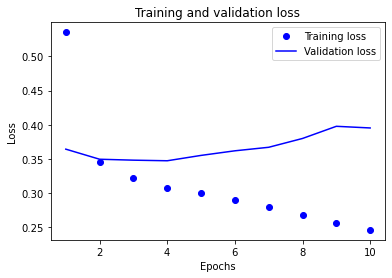

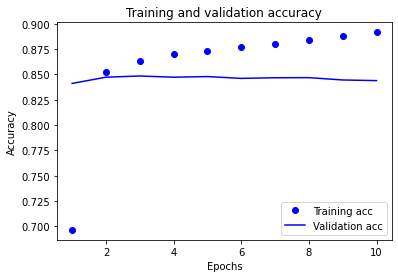

In [20]:
import matplotlib.pyplot as plt

# 모델 1) LSTM

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

#Training and validation loss

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


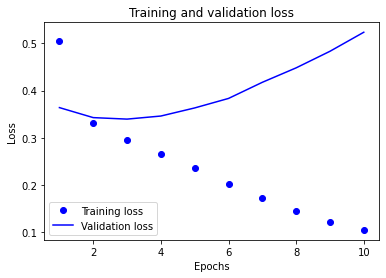

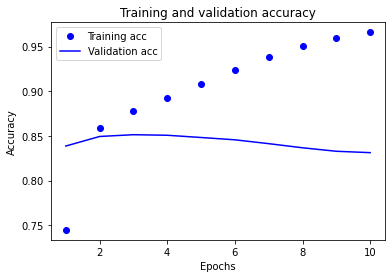

In [21]:
# 모델 2) 1-D Convolution Neural Network

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

#Training and validation loss

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

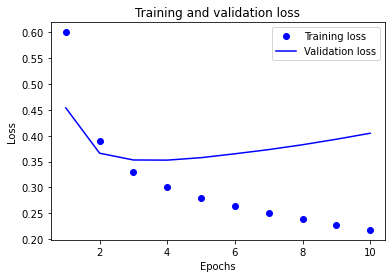

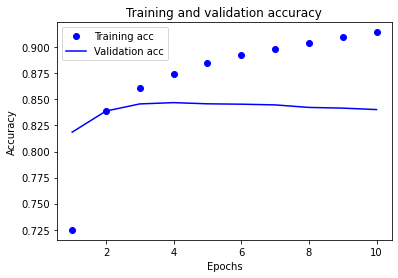

In [22]:
# 모델 3) GlobalMaxPooling1D

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

#Training and validation loss

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있다.

이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 된다고 한다. 

정확히 Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.





### 7. 학습된 Embedding 레이어 분석

In [23]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [24]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀

# 단어 개수에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
# 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기쁨']
vector

array([ 0.02010353, -0.07949317, -0.03985089, -0.04532466, -0.03802413,
        0.11952399,  0.03039351,  0.02816137, -0.02969262, -0.08326288,
        0.01956503, -0.02796807,  0.01969678, -0.01289558, -0.08565721,
        0.01892404], dtype=float32)

In [26]:
# 유사도 확인하기
word_vectors.similar_by_word('기쁨')

[('얼른', 0.9289135932922363),
 ('57', 0.9273546934127808),
 ('거북이', 0.9244694709777832),
 ('모임', 0.9221800565719604),
 ('아이언맨', 0.9216659069061279),
 ('화제', 0.9203674793243408),
 ('열차', 0.9178561568260193),
 ('하치', 0.9148716926574707),
 ('바랍니다', 0.913074254989624),
 ('지금껏', 0.9097740054130554)]

### 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://github.com/Kyubyong/wordvectors

In [27]:
#한국어 Word2Vec 임베딩 활용하여 성능개선

from gensim.models import Word2Vec
word2vec_path =os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['기쁨']
vector

/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.42499185, -0.88340795,  1.1742866 , -0.37539056, -0.04682676,
       -0.07525889,  0.8223606 ,  0.26561314, -0.11154146,  0.6925671 ,
        0.32495   ,  1.0484054 ,  0.69652104,  0.45334858,  0.52098846,
       -0.26825732,  1.4576784 ,  1.0799491 , -0.11510854,  0.17222354,
       -0.8877072 ,  0.7452991 , -0.00476762,  0.8347252 ,  1.0474402 ,
        0.65593   ,  0.3476619 , -0.55307466, -1.8089314 , -0.32093528,
        0.83556795, -0.05392965, -1.1813309 , -0.46805742,  0.9135029 ,
        0.13831933, -0.10430583, -0.6614367 ,  0.65725005,  0.928906  ,
        0.0680275 ,  0.6955746 ,  0.25876808, -1.3328902 , -0.57646114,
       -0.46262547, -0.3608107 , -0.08881398, -0.3610383 ,  0.7712716 ,
        0.09326365, -0.83754617,  0.5800214 , -0.04183557, -0.25951833,
       -0.21794263,  0.0334542 , -1.0801933 , -0.66108954,  0.83394164,
        0.25119692,  1.1920689 ,  0.11266544, -0.4103336 ,  0.20081067,
        0.02321292, -0.33556274,  1.4372654 ,  1.0302697 , -0.44

In [28]:
word2vec.similar_by_word("기쁨")

/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('즐거움', 0.7912124395370483),
 ('슬픔', 0.7767106294631958),
 ('아름다움', 0.6815950870513916),
 ('웃음', 0.6811692714691162),
 ('괴로움', 0.6798388957977295),
 ('행운', 0.6609852910041809),
 ('인생', 0.6571204662322998),
 ('젊음', 0.6522527933120728),
 ('영광', 0.6512227654457092),
 ('행복', 0.6493781805038452)]

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [30]:
embedding_matrix.shape

(10000, 200)

In [31]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 모델 학습
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                    epochs=10, batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

model_results = model.evaluate(X_test, y_test, verbose=2)

print(model_results)

Epoch 1/10
908/908 [==============================] - 17s 18ms/step - loss: 0.5515 - accuracy: 0.6796 - val_loss: 0.3866 - val_accuracy: 0.8344
Epoch 2/10
908/908 [==============================] - 17s 18ms/step - loss: 0.3498 - accuracy: 0.8507 - val_loss: 0.3490 - val_accuracy: 0.8481
Epoch 3/10
908/908 [==============================] - 17s 18ms/step - loss: 0.3078 - accuracy: 0.8715 - val_loss: 0.3422 - val_accuracy: 0.8549
Epoch 4/10
908/908 [==============================] - 16s 18ms/step - loss: 0.2838 - accuracy: 0.8830 - val_loss: 0.3422 - val_accuracy: 0.8550
Epoch 5/10
908/908 [==============================] - 16s 18ms/step - loss: 0.2633 - accuracy: 0.8924 - val_loss: 0.3496 - val_accuracy: 0.8543
Epoch 6/10
908/908 [==============================] - 16s 18ms/step - loss: 0.2458 - accuracy: 0.8999 - val_loss: 0.3605 - val_accuracy: 0.8532
Epoch 7/10
908/908 [==============================] - 16s 18ms/step - loss: 0.2290 - accuracy: 0.9081 - val_loss: 0.3669 - val_accuracy:

In [33]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


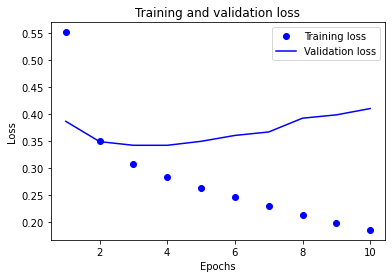

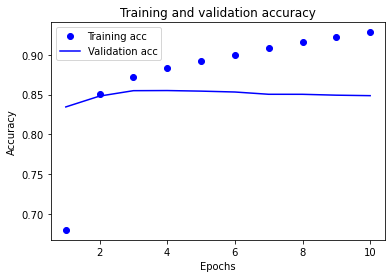

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

## 느낀점

- 이전 노드들과 달리 뭔가 갑자기 이해가 더 잘 안갔던 내용들이었다. 분명히 내가 하던 레이어를 구성하고 데이터를 불러와서 하는 작업의 결은 비슷하다고 생각했는데 지금까지도 내가 잘 분석한건가 싶은 애매한 느낌이 들었다.
- 텍스트를 토큰화한다, 관련없는 단어나, 표현들을 거른다? 등의 과정들이 어색하긴 헀는데 어떤 원리로 이루어지는지는 감을 잡은것 같다.

- 아직 각 모델들에 대해서도 왜 성능이 좋은지, 어느 목적에 더 알맞은 모델인지는 사실 잘 모르겠다. 그렇지만 성능 결과로 대략적으로 '아 이모델이 좀더 괜찮구나'를 알수있었다.

- 팀원분 중에 'pre-padding', 'post-padding'에 관해서 직접 데이터를 넣어보시고 결과를 비교하신다고 하여 궁금해서 나도 진행해 보았는데 이론상엔 pre가 post보다 10%좋은 성능을 보인다고 했는데 오늘 진행했던 E6노드에서도 그렇고 이번 노드에서도 그렇고 post-padding이 더 나은 결과를 얻었다. 퍼실님께서 이론과 실제간의 괴리?가 존재하는 것 같다고 하셔서 어느 분야에, 어떤곳에 적용하느냐에 따라서 달라지는건가 싶었다. 

- 각 모델마다 그래프를 비교할 수 있도록 했는데 처음에 다 똑같은 그래프가 나와서 변수 지정을 다르게 했어야했는데 실수를 했다. 다음부터 꼼꼼하게 더 살펴야겠다.

- 한국어 Word2Vec임베딩을 활용하면 85%넘는 결과를 얻는 분들이 계시다고 들었는데,,, 84%조금 넘은 LSTM처음 모델보다 좋은 결과이긴 한데 조금 아쉬웠다. 다시 찾아보고 85%꼭 넘겨보고싶다.


## 부족한점

- 그래프를 정확히 보고 어느 부분이 문제인지 알아보는 것을 더 찾아봐야겠다.
- 나름 그동안 배운 것을 토대로 하이퍼파라미터를 조정해서 결과를 더 높여보고 싶었는데 역시나 내가 생각했던대로나 이리저리 찾아보았던 것만큼 결과가 잘 나오지 않아서 답답했다. 
- 팀원분의 그래프를 보니 그냥 오 학습이 잘된 모델인건가? 라는 생각이 들었는데 어떤 부분에서 내가 놓친 건지 한번 비교 해보고싶다.
- 이번 노드 전체적으로 이해가 부족하다. 이미지 인식이 오히려 더 쉬웠다고 생각이 들게끔하는 프로젝트였다. 각 모델들에 대한 기본적인 개념은 어느정도 학습했다고 생각했는데 아직 부족함이 너무 많은것 같다. 
- 더 다양한 모델들을 적용해봐야겠다. lstm모델도 여러 레이어를 추가해서 해보고 저번 노드에서도 적용해본 dropout레이어도 추가해보면서 여러가지 방법을 시도해서 결과를 확인하는 것도 모델을 이해하는데 도움이 될 것 같다. 
- 노드 제출할 때쯤은 어느정도 괜찮다! 이런 느낌이 나고 나서 제출을 하는데 이번노드는 조금 찜찜하게 제출하는 것같다. 다시한번 찬찬히 lms를 읽어보면서 복습을 해봐야겠다. 

**+ 그래프알기**

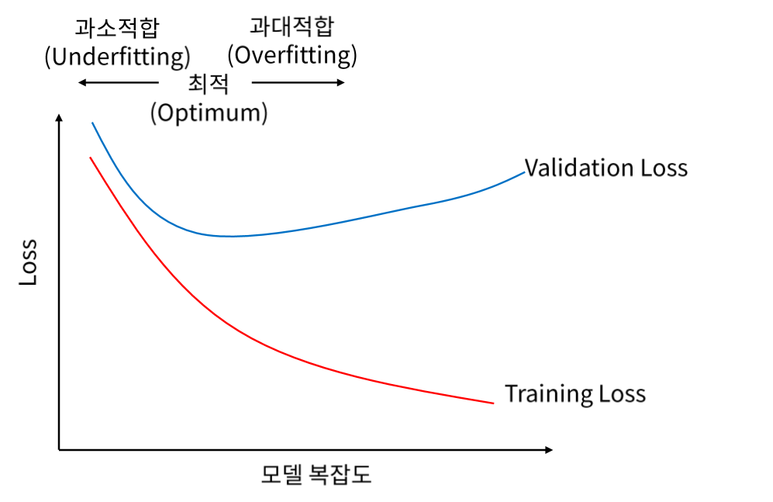

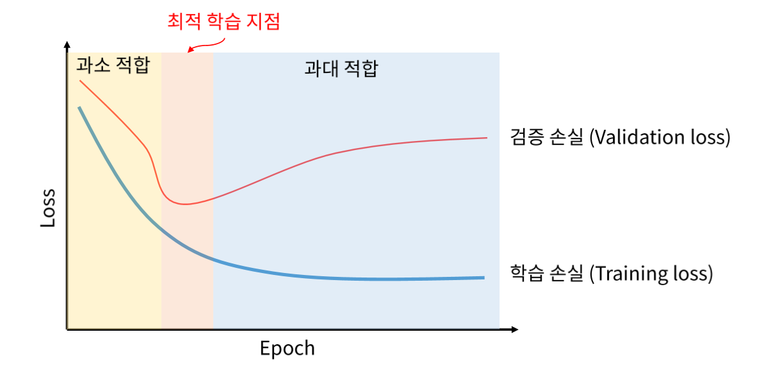

일반적으로 문제의 난이도에 비해 모델의 복잡도가 너무 낮으면 과소 적합, 너무 높으면 과대 적합이 발생한다.

Dropout과 Keras를 이용한 EarlyStopper callback 

[과소적합, 과대적합](https://blog.naver.com/jeonghj66/222004874975)